# Gas Import Forecasting Analysis

This notebook analyzes gas import data from multiple countries and implements various forecasting models to predict future imports.

## Data Overview
- Countries: Algeria, Libya, Iran, Azerbaijan, Norway, Russia
- Time Period: January 2018 - July 2025
- Missing values present in Iran column
- Monthly frequency data


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import forecasting libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# TensorFlow is optional; wrap import to avoid blocking if not installed
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.optimizers import Adam
    print(f"TensorFlow available: {tf.__version__}")
except Exception:
    tf = None
    print("TensorFlow not installed; proceeding without LSTM models.")

print("Libraries imported successfully!")

TensorFlow not installed; proceeding without LSTM models.
Libraries imported successfully!


## Project setup
We'll load pipeline import data from `Copy of Excel-Pipeline Supply to Europe.xlsm`, detect available import routes (columns), and run per-route forecasts with robust defaults. You can tweak the config in the next cell.

In [25]:
# --- Configuration ---
from pathlib import Path
DATA_FILE = Path(r"Copy of Excel-Pipeline Supply to Europe.xlsm")
DATE_COL_CANDIDATES = ["date", "month", "period", "Date", "Month", "Period"]
ROUTE_EXCLUDE_KEYWORDS = ["total", "sum"]  # columns with these tokens will be excluded from route list
FORECAST_HORIZON = 12  # months
FREQ = "MS"  # Month Start
TEST_SIZE = 12  # last N periods for backtest/evaluation
OUTPUT_DIR = Path("forecasts_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)
print("Config ready:", DATA_FILE.resolve())

Config ready: C:\Users\tcrump\OneDrive - FACTS Global Energy Pte Ltd\Desktop\Coding projects\Copy of Excel-Pipeline Supply to Europe.xlsm


In [26]:
# Load a sheet named "speedsheet" (case-insensitive) from the workbook, with sensible fallbacks.
xls = pd.ExcelFile(DATA_FILE)
print("Workbook sheets:", xls.sheet_names)

# find a sheet called "speedsheet" (case-insensitive)
target_sheet = next((s for s in xls.sheet_names if s.lower() == "speedsheet"), None)

# fallback to selected_sheet if defined and present, otherwise use the first sheet
if target_sheet is None:
    if 'selected_sheet' in globals() and selected_sheet in xls.sheet_names:
        target_sheet = selected_sheet
        print(f"'speedsheet' not found; falling back to selected_sheet: {selected_sheet}")
    else:
        target_sheet = xls.sheet_names[0]
        print(f"'speedsheet' not found; falling back to first sheet: {target_sheet}")

# read the sheet
df_speedsheet = pd.read_excel(DATA_FILE, sheet_name=target_sheet)
print(f"Loaded sheet '{target_sheet}' with shape {df_speedsheet.shape}")

# attempt to detect date column using DATE_COL_CANDIDATES (case-insensitive)
date_col = None
cols_map = {c.lower(): c for c in df_speedsheet.columns}
for cand in DATE_COL_CANDIDATES:
    if cand.lower() in cols_map:
        date_col = cols_map[cand.lower()]
        break

# additional heuristic if not found
if date_col is None:
    for c in df_speedsheet.columns:
        if any(token in str(c).lower() for token in ("date", "month", "period")):
            date_col = c
            break

if date_col is None:
    print("No date column detected. Dataframe left as-is. Columns:", list(df_speedsheet.columns))
else:
    # parse and set datetime index
    df_speedsheet[date_col] = pd.to_datetime(df_speedsheet[date_col], errors='coerce')
    df_speedsheet = df_speedsheet.set_index(date_col).sort_index()
    try:
        df_speedsheet = df_speedsheet.asfreq(FREQ)
    except Exception:
        # if asfreq fails, keep the index as-is
        pass
    print(f"Set index to '{date_col}'. Range: {df_speedsheet.index.min()} -> {df_speedsheet.index.max()} (freq={FREQ})")

# coerce numeric columns
for c in df_speedsheet.columns:
    df_speedsheet[c] = pd.to_numeric(df_speedsheet[c], errors='coerce')

# expose a clear variable for downstream cells
speedsheet = df_speedsheet.copy()

# quick preview
print("speedsheet preview:")
print(speedsheet)

Workbook sheets: ['Sheet1']
'speedsheet' not found; falling back to selected_sheet: Sheet1
Loaded sheet 'Sheet1' with shape (108, 10)
Set index to 'Month'. Range: 2018-01-01 00:00:00 -> 2026-12-01 00:00:00 (freq=MS)
speedsheet preview:
            Year  Days in Month      Algeria       Libya        Iran  \
Month                                                                  
2018-01-01  2018             31  4239.162936  358.000000  951.961290   
2018-02-01  2018             28  4338.118069  432.801011  863.589286   
2018-03-01  2018             31  4224.964454  559.756465  841.506452   
2018-04-01  2018             30  3104.056450   16.088201  938.980000   
2018-05-01  2018             31  2663.250106  249.226631  569.354839   
...          ...            ...          ...         ...         ...   
2026-08-01  2026             31  2760.576469  124.125241  488.458480   
2026-09-01  2026             30  2703.838966  123.174642  487.381442   
2026-10-01  2026             31  3073.091097

In [27]:
# Split df_combined so forecasts are after Jul-2025 (i.e. > 2025-07-01)
cutoff = pd.to_datetime("2025-07-01")

# ensure datetime index
if not isinstance(df_combined.index, pd.DatetimeIndex):
    df_combined.index = pd.to_datetime(df_combined.index)

# history includes Jul-2025, forecasts are everything after
df_history = df_combined.loc[:cutoff].copy()
df_forecast_period = df_combined.loc[df_combined.index > cutoff].copy()

print("Cutoff:", cutoff.date())
print("History shape:", df_history.shape, "range:", df_history.index.min(), "->", df_history.index.max())
print("Forecast-period shape:", df_forecast_period.shape,
      "range:", (df_forecast_period.index.min() if len(df_forecast_period) else None),
      "->", (df_forecast_period.index.max() if len(df_forecast_period) else None))

Cutoff: 2025-07-01
History shape: (91, 6) range: 2018-01-01 00:00:00 -> 2025-07-01 00:00:00
Forecast-period shape: (29, 6) range: 2025-08-01 00:00:00 -> 2027-12-01 00:00:00


Saved plot to: forecasts_outputs\actuals_vs_forecast_by_route.png


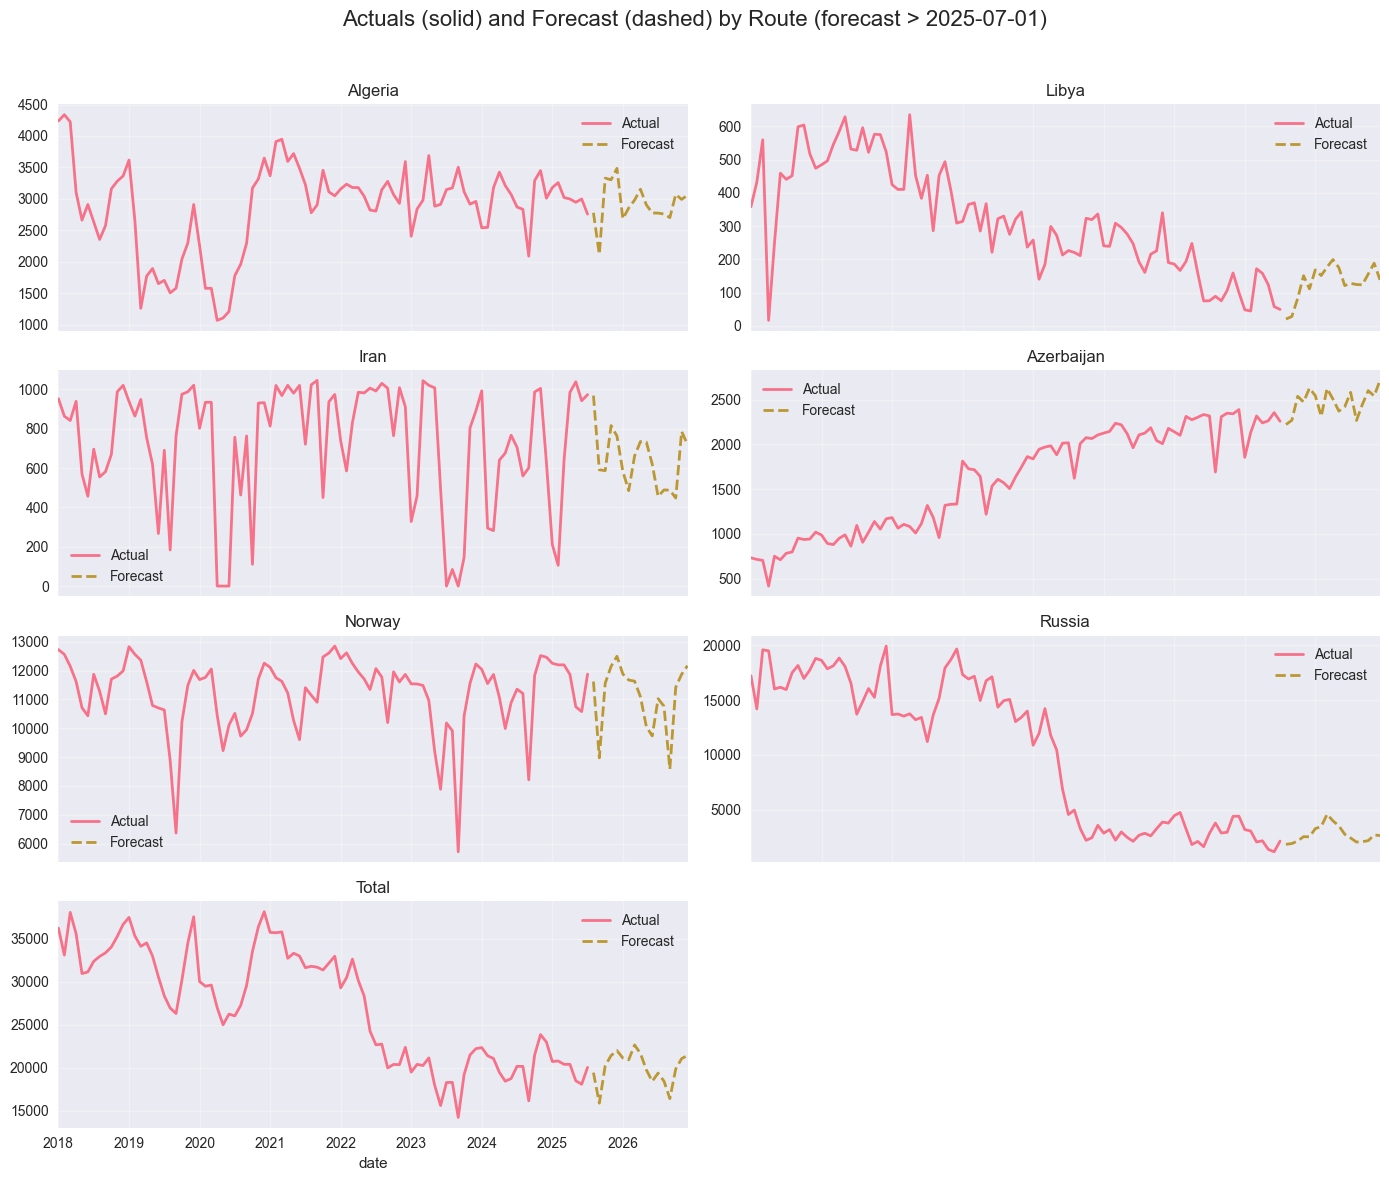

In [29]:
# Plot actuals for each route + Total in subplots and save to outputs (split actuals vs forecast)
cols = ['Algeria', 'Libya', 'Iran', 'Azerbaijan', 'Norway', 'Russia']

# build plotting dataframe (use speedsheet Total if available, otherwise sum)
df_plot = df_actuals[cols].copy()
if 'Total' in speedsheet.columns:
    df_plot['Total'] = speedsheet['Total']
else:
    df_plot['Total'] = df_plot.sum(axis=1)

# split at cutoff (forecast = everything after Jul-2025)
actual = df_plot.loc[:cutoff]
forecast = df_plot.loc[df_plot.index > cutoff]

# create subplots (4x2 -> 8 slots, 7 series)
fig, axes = plt.subplots(4, 2, figsize=(14, 12), sharex=True)
axes = axes.flatten()

for i, col in enumerate(cols + ['Total']):
    ax = axes[i]
    # plot actuals (solid)
    if col in actual.columns and not actual[col].dropna().empty:
        actual[col].plot(ax=ax, linewidth=2, label='Actual', color='C0')
    # plot forecast (dashed) if any values exist after cutoff
    if col in forecast.columns and not forecast[col].dropna().empty:
        forecast[col].plot(ax=ax, linewidth=2, linestyle='--', label='Forecast', color='C1')
    ax.set_title(col)
    ax.grid(alpha=0.3)
    ax.legend()

# remove the unused axis (last one)
if len(cols) + 1 < len(axes):
    fig.delaxes(axes[-1])

fig.suptitle("Actuals (solid) and Forecast (dashed) by Route (forecast > 2025-07-01)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

out_path = OUTPUT_DIR / "actuals_vs_forecast_by_route.png"
fig.savefig(out_path, dpi=150)
print("Saved plot to:", out_path)
plt.show()

In [31]:
# --- Forecasting utilities: Seasonal Naive + ETS (Holt-Winters) ---
import numpy as np
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

DEF_SEASONAL_PERIODS = 12

def _clean_series(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors="coerce")
    s = s.interpolate(limit_direction="both")
    s = s.fillna(method="ffill").fillna(method="bfill")
    return s

def forecast_seasonal_naive(series: pd.Series, horizon: int, m: int = DEF_SEASONAL_PERIODS) -> pd.Series:
    s = _clean_series(series)
    if m <= 0:
        m = DEF_SEASONAL_PERIODS
    if len(s.dropna()) == 0:
        return pd.Series([np.nan] * horizon)
    if len(s) < m:
        last_val = s.iloc[-1]
        return pd.Series([last_val] * horizon)
    last_cycle = s.iloc[-m:]
    reps = int(np.ceil(horizon / m))
    vals = np.tile(last_cycle.values, reps)[:horizon]
    return pd.Series(vals)

def forecast_ets(series: pd.Series, horizon: int, m: int = DEF_SEASONAL_PERIODS) -> pd.Series:
    s = _clean_series(series)
    if len(s.dropna()) < (m * 2):
        # not enough data for seasonal ETS; fallback to simple exponential smoothing via ETS without seasonality
        try:
            model = ExponentialSmoothing(s, trend=None, seasonal=None)
            fit = model.fit(optimized=True)
            return pd.Series(fit.forecast(horizon).values)
        except Exception:
            return forecast_seasonal_naive(series, horizon, m)
    # try additive seasonality first; fallback to multiplicative
    for seasonal in ("add", "mul"):
        try:
            model = ExponentialSmoothing(s, trend=None, seasonal=seasonal, seasonal_periods=m)
            fit = model.fit(optimized=True)
            return pd.Series(fit.forecast(horizon).values)
        except Exception:
            continue
    # last fallback
    return forecast_seasonal_naive(series, horizon, m)

print("Forecasting utilities ready: seasonal naive and ETS.")

Forecasting utilities ready: seasonal naive and ETS.


Saved alternative forecasts to: forecasts_outputs\alternative_forecasts.csv
Saved comparison plot: forecasts_outputs\comparison_Algeria.png


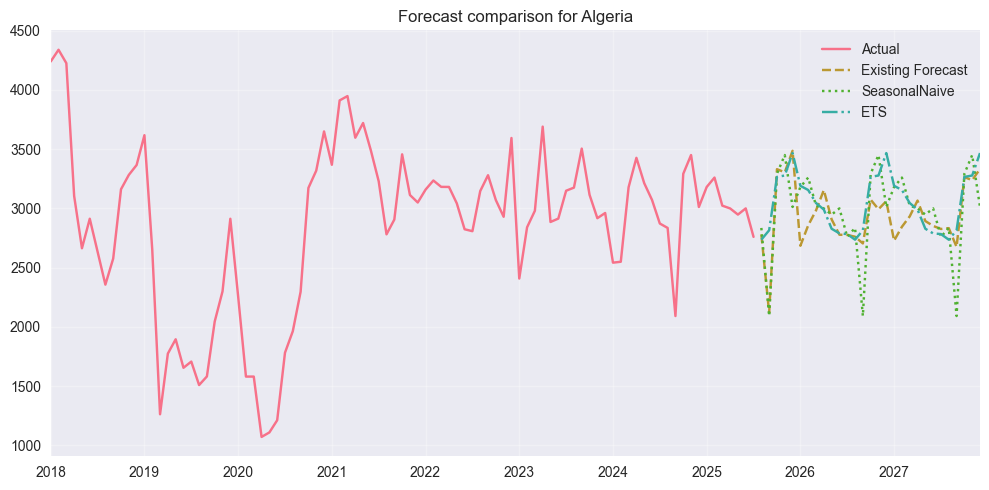

In [32]:
# --- Compare alternative forecasts with existing forecast period ---
# Inputs expected: df_history, df_forecast_period, FREQ, FORECAST_HORIZON, routes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Determine horizon based on forecast_period rows, else use default
if 'df_forecast_period' in globals() and len(df_forecast_period) > 0:
    horizon = len(df_forecast_period)
else:
    # build a future index and use default horizon
    last_observed = df_history.index.max() if 'df_history' in globals() else speedsheet.index.max()
    future_idx = pd.date_range(last_observed + pd.offsets.MonthBegin(1), periods=FORECAST_HORIZON, freq=FREQ)
    df_forecast_period = pd.DataFrame(index=future_idx)
    horizon = FORECAST_HORIZON

alts = {}
for route in routes:
    series = df_history[route] if 'df_history' in globals() else speedsheet[route]
    series = series.asfreq(FREQ)
    # align future index to the constructed forecast period
    idx_future = df_forecast_period.index
    # seasonal naive
    sn = forecast_seasonal_naive(series, horizon)
    sn.index = idx_future
    # ETS
    ets = forecast_ets(series, horizon)
    ets.index = idx_future
    alts[(route, 'SeasonalNaive')] = sn
    alts[(route, 'ETS')] = ets

# assemble dataframe: MultiIndex columns (method -> route) then flatten
methods = sorted(set(m for _, m in alts.keys()))
alt_cols = []
frames = []
for m in methods:
    df_m = pd.DataFrame({r: alts[(r, m)] for r in routes}, index=df_forecast_period.index)
    df_m.columns = pd.MultiIndex.from_product([[m], df_m.columns])
    frames.append(df_m)
alt_df = pd.concat(frames, axis=1).sort_index(axis=1)
alt_df.columns = [f"{m}_{r}" for m, r in alt_df.columns]

# Save alternative forecasts
out_csv = OUTPUT_DIR / "alternative_forecasts.csv"
alt_df.to_csv(out_csv)
print("Saved alternative forecasts to:", out_csv)

# Quick comparison plot for one route
route_example = routes[0] if routes else None
if route_example is not None:
    plt.figure(figsize=(10,5))
    # plot history
    (df_history[route_example] if 'df_history' in globals() else speedsheet[route_example]).plot(label='Actual', color='C0')
    # existing forecast if present
    if 'df_forecast_period' in globals() and route_example in df_forecast_period.columns:
        df_forecast_period[route_example].plot(label='Existing Forecast', linestyle='--', color='C1')
    # alternatives
    alt_df[f'SeasonalNaive_{route_example}'].plot(label='SeasonalNaive', linestyle=':', color='C2')
    alt_df[f'ETS_{route_example}'].plot(label='ETS', linestyle='-.', color='C3')
    plt.title(f"Forecast comparison for {route_example}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    out_png = OUTPUT_DIR / f"comparison_{route_example}.png"
    plt.savefig(out_png, dpi=150)
    print("Saved comparison plot:", out_png)
    plt.show()
else:
    print("No routes detected; nothing to plot.")

,route,method,MAE_to_existing,RMSE_to_existing,MAPE_to_existing
2,Algeria,SARIMAX,136.114087,207.179189,4.970886
1,Algeria,ETS,156.690326,231.663728,5.720987
3,Algeria,XGB,203.020988,272.275944,7.391658
0,Algeria,SeasonalNaive,205.770190,280.731916,7.084998
4,Algeria,RF,217.425383,292.028004,7.938373
17,Azerbaijan,SARIMAX,138.405998,169.282916,5.544515
19,Azerbaijan,RF,205.254284,233.733077,8.075238
16,Azerbaijan,ETS,212.776964,231.583832,8.429773
18,Azerbaijan,XGB,237.773420,254.572278,9.551968
15,Azerbaijan,SeasonalNaive,268.334742,320.561460,10.884154


Saved metrics to: forecasts_outputs\alternative_vs_existing_metrics.csv
Saved metrics plot to: forecasts_outputs\metrics_vs_existing_Algeria.png


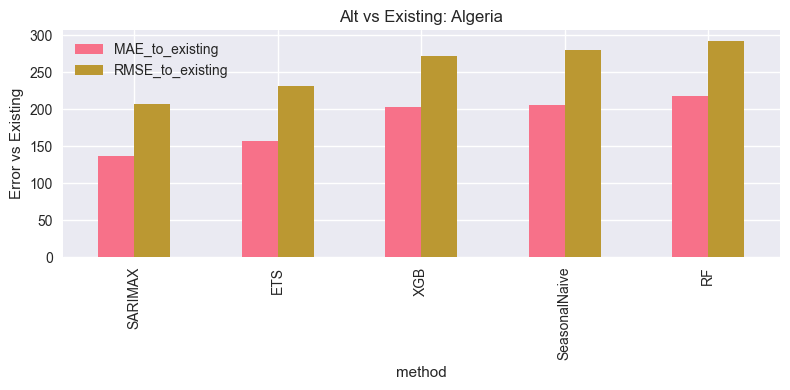

In [36]:
# --- Metrics: alternative vs existing forecasts ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _mae(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.nanmean(np.abs(a - b)))

def _rmse(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    return float(np.sqrt(np.nanmean((a - b) ** 2)))

def _mape(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    mask = a != 0
    if not np.any(mask):
        return np.nan
    return float(np.nanmean(np.abs((a[mask] - b[mask]) / a[mask])) * 100.0)

metrics = []
for route in routes:
    if 'df_forecast_period' not in globals() or route not in df_forecast_period.columns:
        continue
    y_ref = pd.to_numeric(df_forecast_period[route], errors='coerce')
    for method in ['SeasonalNaive', 'ETS']:
        col = f'{method}_{route}'
        if 'alt_df' in globals() and col in alt_df.columns:
            y_alt = pd.to_numeric(alt_df[col], errors='coerce').reindex(y_ref.index)
            metrics.append({
                'route': route,
                'method': method,
                'MAE_to_existing': _mae(y_ref, y_alt),
                'RMSE_to_existing': _rmse(y_ref, y_alt),
                'MAPE_to_existing': _mape(y_ref, y_alt),
            })
    # include advanced methods if present
    for method in ['SARIMAX', 'XGB', 'RF', 'NeuralProphet']:
        col = f'{method}_{route}'
        if 'adv_df' in globals() and col in adv_df.columns:
            y_alt = pd.to_numeric(adv_df[col], errors='coerce').reindex(y_ref.index)
            metrics.append({
                'route': route,
                'method': method,
                'MAE_to_existing': _mae(y_ref, y_alt),
                'RMSE_to_existing': _rmse(y_ref, y_alt),
                'MAPE_to_existing': _mape(y_ref, y_alt),
            })

metrics_df = pd.DataFrame(metrics).sort_values(['route', 'MAE_to_existing'])
display(metrics_df)

# Save metrics
metrics_path = OUTPUT_DIR / 'alternative_vs_existing_metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print('Saved metrics to:', metrics_path)

# optional: bar chart for one route
route_example = routes[0] if routes else None
if route_example and (metrics_df['route'] == route_example).any():
    plot_df = metrics_df[metrics_df['route'] == route_example].set_index('method')
    ax = plot_df[['MAE_to_existing','RMSE_to_existing']].plot(kind='bar', figsize=(8,4), title=f"Alt vs Existing: {route_example}")
    ax.set_ylabel('Error vs Existing')
    plt.tight_layout()
    out_png = OUTPUT_DIR / f"metrics_vs_existing_{route_example}.png"
    plt.savefig(out_png, dpi=150)
    print('Saved metrics plot to:', out_png)
    plt.show()
else:
    print('No metrics to plot for example route.')

In [34]:
# --- Advanced forecasting utilities: SARIMAX, XGBoost, RandomForest, NeuralProphet (optional) ---
import warnings
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def _clean(s: pd.Series) -> pd.Series:
    s = pd.to_numeric(s, errors='coerce')
    s = s.interpolate(limit_direction='both')
    s = s.fillna(method='ffill').fillna(method='bfill')
    return s

def fit_sarimax_quick(series: pd.Series, m: int = 12):
    y = _clean(series).asfreq(FREQ)
    best_model = None
    best_aic = np.inf
    best_order = None
    best_seasonal = None
    for p in (0,1,2):
        for d in (0,1):
            for q in (0,1,2):
                order = (p,d,q)
                for P in (0,1):
                    for D in (0,1):
                        for Q in (0,1):
                            seas = (P,D,Q,m)
                            try:
                                with warnings.catch_warnings():
                                    warnings.simplefilter('ignore')
                                    model = SARIMAX(y, order=order, seasonal_order=seas, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                                if model.aic < best_aic:
                                    best_aic = model.aic
                                    best_model = model
                                    best_order = order
                                    best_seasonal = seas
                            except Exception:
                                continue
    return best_model, best_order, best_seasonal, best_aic

def build_supervised(series: pd.Series, lags: int = 12, add_month=True) -> tuple[pd.DataFrame, pd.Series]:
    y = _clean(series).asfreq(FREQ)
    df = pd.DataFrame({'y': y})
    for L in range(1, lags+1):
        df[f'lag_{L}'] = df['y'].shift(L)
    if add_month:
        df['month'] = df.index.month
        month_dummies = pd.get_dummies(df['month'], prefix='m', drop_first=False)
        df = pd.concat([df.drop(columns=['month']), month_dummies], axis=1)
    df = df.dropna()
    X = df.drop(columns=['y'])
    y = df['y']
    return X, y

def forecast_ml_recursive(series: pd.Series, horizon: int, model: str = 'xgb', lags: int = 12) -> pd.Series:
    y = _clean(series).asfreq(FREQ)
    X, Y = build_supervised(y, lags=lags, add_month=True)
    if model == 'xgb':
        reg = XGBRegressor(n_estimators=400, max_depth=4, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9, random_state=42)
    elif model == 'rf':
        reg = RandomForestRegressor(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1)
    else:
        raise ValueError("model must be 'xgb' or 'rf'")
    reg.fit(X.values, Y.values)
    # recursive forecasting
    history = y.copy()
    preds = []
    for h in range(horizon):
        # build one-step feature vector from latest history
        values = history.values
        feats = {}
        for L in range(1, lags+1):
            feats[f'lag_{L}'] = values[-L] if len(values) >= L else values[0]
        # month dummies for next step
        next_ts = (history.index[-1] + pd.offsets.MonthBegin(1)) if len(history) else pd.Timestamp.today().to_period('M').to_timestamp()
        m = next_ts.month
        for k in range(1,13):
            feats[f'm_{k}'] = 1 if m == k else 0
        # ensure column order matches training
        feat_row = [feats.get(col, 0) for col in X.columns]
        yhat = reg.predict(np.array(feat_row).reshape(1,-1))[0]
        # append to preds and history
        preds.append(yhat)
        history = pd.concat([history, pd.Series([yhat], index=[next_ts])])
    return pd.Series(preds)

def forecast_neuralprophet(series: pd.Series, horizon: int):
    try:
        from neuralprophet import NeuralProphet
    except Exception:
        return None  # not installed
    df = pd.DataFrame({'ds': series.index, 'y': _clean(series).values})
    m = NeuralProphet(seasonality_mode='additive', yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, n_forecasts=1, n_lags=0)
    m = m.fit(df, freq='MS', progress='none', minimal=True)
    future = m.make_future_dataframe(df, periods=horizon, n_historic_predictions=False)
    fcst = m.predict(future)
    yhat = fcst['yhat1'].tail(horizon).reset_index(drop=True)
    return pd.Series(yhat.values)

print("Advanced forecasting utilities ready (SARIMAX, XGB, RF, optional NeuralProphet).")

Advanced forecasting utilities ready (SARIMAX, XGB, RF, optional NeuralProphet).


In [37]:
# --- Generate advanced forecasts (aligned with df_forecast_period) ---
# Requires: routes, df_history (or speedsheet), df_forecast_period, FREQ
if 'df_forecast_period' in globals() and len(df_forecast_period) > 0:
    horizon_adv = len(df_forecast_period)
    future_idx = df_forecast_period.index
else:
    last_observed = df_history.index.max() if 'df_history' in globals() else speedsheet.index.max()
    future_idx = pd.date_range(last_observed + pd.offsets.MonthBegin(1), periods=FORECAST_HORIZON, freq=FREQ)
    horizon_adv = FORECAST_HORIZON
adv = {}
for route in routes:
    series = df_history[route] if 'df_history' in globals() else speedsheet[route]
    series = series.asfreq(FREQ)
    # SARIMAX
    model, order, seas, aic = fit_sarimax_quick(series, m=12)
    if model is not None:
        sar = model.get_forecast(steps=horizon_adv).predicted_mean
        sar.index = future_idx
        adv[(route, 'SARIMAX')] = sar
    # XGBoost
    try:
        xgb = forecast_ml_recursive(series, horizon_adv, model='xgb', lags=12)
        xgb.index = future_idx
        adv[(route, 'XGB')] = xgb
    except Exception as e:
        print(f"XGB failed for {route}: {e}")
    # RandomForest
    try:
        rf = forecast_ml_recursive(series, horizon_adv, model='rf', lags=12)
        rf.index = future_idx
        adv[(route, 'RF')] = rf
    except Exception as e:
        print(f"RF failed for {route}: {e}")
    # NeuralProphet (optional)
    np_fc = forecast_neuralprophet(series, horizon_adv)
    if np_fc is not None:
        np_fc.index = future_idx
        adv[(route, 'NeuralProphet')] = np_fc

# assemble dataframe
methods_adv = sorted(set(m for _, m in adv.keys()))
frames = []
for m in methods_adv:
    df_m = pd.DataFrame({r: adv[(r, m)] for r in routes if (r, m) in adv}, index=future_idx)
    df_m.columns = pd.MultiIndex.from_product([[m], df_m.columns])
    frames.append(df_m)
adv_df = pd.concat(frames, axis=1).sort_index(axis=1) if frames else pd.DataFrame(index=future_idx)
adv_df.columns = [f"{m}_{r}" for m, r in adv_df.columns] if not adv_df.empty else adv_df.columns
out_csv = OUTPUT_DIR / "advanced_forecasts.csv"
adv_df.to_csv(out_csv)
print("Saved advanced forecasts to:", out_csv)

# quick example plot (Plotly)
route_example = routes[0] if routes else None
if route_example is not None:
    import plotly.graph_objects as go
    fig = go.Figure()
    # Actuals
    hist_series = (df_history[route_example] if 'df_history' in globals() else speedsheet[route_example])
    fig.add_trace(go.Scatter(x=hist_series.index, y=hist_series.values, mode='lines', name='Actual', line=dict(color='#1f77b4')))
    # Existing forecast (if present)
    if 'df_forecast_period' in globals() and route_example in df_forecast_period.columns:
        ref_series = df_forecast_period[route_example]
        fig.add_trace(go.Scatter(x=ref_series.index, y=ref_series.values, mode='lines', name='Existing Forecast', line=dict(color='#ff7f0e', dash='dash')))
    # Advanced methods
    for m in methods_adv:
        col = f"{m}_{route_example}"
        if col in adv_df.columns:
            series = adv_df[col]
            fig.add_trace(go.Scatter(x=series.index, y=series.values, mode='lines', name=m))
    fig.update_layout(
        title=f"Advanced forecasts for {route_example}",
        xaxis_title='Date',
        yaxis_title='Volume',
        template='plotly_white',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0)
    )
    out_html = OUTPUT_DIR / f"advanced_comparison_{route_example}.html"
    fig.write_html(str(out_html))
    print("Saved advanced comparison (Plotly) to:", out_html)
    fig.show()
else:
    print("No routes detected.")

Saved advanced forecasts to: forecasts_outputs\advanced_forecasts.csv
Saved advanced comparison (Plotly) to: forecasts_outputs\advanced_comparison_Algeria.html


In [38]:
# --- Plotly: route dropdown + small multiples ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math

if routes:
    # 1) Single figure with dropdown to switch route
    fig_dd = go.Figure()
    route_groups = []  # list of (route, start_idx, end_idx) for visibility control
    total_traces = 0

    for route in routes:
        # Actuals
        hist = (df_history[route] if 'df_history' in globals() else speedsheet[route])
        fig_dd.add_trace(go.Scatter(x=hist.index, y=hist.values, mode='lines', name=f'Actual ({route})',
                                     line=dict(color='#1f77b4')))
        # Existing forecast (if present)
        if 'df_forecast_period' in globals() and route in df_forecast_period.columns:
            ref = df_forecast_period[route]
            fig_dd.add_trace(go.Scatter(x=ref.index, y=ref.values, mode='lines', name=f'Existing ({route})',
                                         line=dict(color='#ff7f0e', dash='dash')))
        # Advanced methods per route
        if 'adv_df' in globals() and adv_df is not None and not adv_df.empty:
            for m in (methods_adv if 'methods_adv' in globals() else []):
                col = f"{m}_{route}"
                if col in adv_df.columns:
                    ser = adv_df[col]
                    fig_dd.add_trace(go.Scatter(x=ser.index, y=ser.values, mode='lines', name=f'{m} ({route})'))
        # register group span for this route
        start_idx = total_traces
        total_traces = len(fig_dd.data)
        route_groups.append((route, start_idx, total_traces))

    # Build visibility masks for dropdown
    buttons = []
    for i, (route, start, end) in enumerate(route_groups):
        vis = [False] * total_traces
        for j in range(start, end):
            vis[j] = True
        buttons.append(dict(label=route,
                            method='update',
                            args=[{'visible': vis},
                                  {'title': f'Advanced forecasts (Route: {route})'}]))

    # Default: first route visible
    default_vis = [False] * total_traces
    if route_groups:
        s0, e0 = route_groups[0][1], route_groups[0][2]
        for j in range(s0, e0):
            default_vis[j] = True

    fig_dd.update_layout(
        title=f"Advanced forecasts (Route: {route_groups[0][0] if route_groups else ''})",
        xaxis_title='Date',
        yaxis_title='Volume',
        template='plotly_white',
        updatemenus=[dict(buttons=buttons, direction='down', x=0.01, y=1.12, xanchor='left', yanchor='top')],
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='left', x=0)
    )
    # apply default visibility
    for k, tr in enumerate(fig_dd.data):
        tr.visible = default_vis[k]
    out_html_dd = OUTPUT_DIR / "advanced_comparison_dropdown.html"
    fig_dd.write_html(str(out_html_dd))
    print("Saved dropdown comparison (Plotly) to:", out_html_dd)
    fig_dd.show()

    # 2) Small multiples (subplots) over all routes
    n = len(routes)
    cols = 3
    rows = math.ceil(n / cols)
    fig_sm = make_subplots(rows=rows, cols=cols, subplot_titles=routes, shared_xaxes=True)

    actual_idx = []  # indices of always-on traces (actual + existing)
    method_trace_indices = {}  # method -> [indices across subplots]
    default_method = 'SARIMAX' if ('methods_adv' in globals() and 'SARIMAX' in methods_adv) else (methods_adv[0] if 'methods_adv' in globals() and methods_adv else None)

    r_i = 1
    c_i = 1
    for route in routes:
        # Actuals
        hist = (df_history[route] if 'df_history' in globals() else speedsheet[route])
        t = fig_sm.add_trace(go.Scatter(x=hist.index, y=hist.values, mode='lines', name='Actual',
                                        line=dict(color='#1f77b4'), showlegend=False), row=r_i, col=c_i)
        actual_idx.append(len(fig_sm.data) - 1)
        # Existing
        if 'df_forecast_period' in globals() and route in df_forecast_period.columns:
            ref = df_forecast_period[route]
            t = fig_sm.add_trace(go.Scatter(x=ref.index, y=ref.values, mode='lines', name='Existing',
                                            line=dict(color='#ff7f0e', dash='dash'), showlegend=False), row=r_i, col=c_i)
            actual_idx.append(len(fig_sm.data) - 1)
        # Advanced methods (one trace per method per route, toggle via dropdown)
        if 'adv_df' in globals() and adv_df is not None and not adv_df.empty and ('methods_adv' in globals()):
            for m in methods_adv:
                col = f"{m}_{route}"
                if col in adv_df.columns:
                    ser = adv_df[col]
                    vis = (m == default_method) if default_method else True
                    t = fig_sm.add_trace(go.Scatter(x=ser.index, y=ser.values, mode='lines', name=m, showlegend=False, visible=vis), row=r_i, col=c_i)
                    idx = len(fig_sm.data) - 1
                    method_trace_indices.setdefault(m, []).append(idx)

        # increment subplot position
        c_i += 1
        if c_i > cols:
            c_i = 1
            r_i += 1

    # Build buttons to toggle advanced method across all subplots (actual/existing stay visible)
    buttons_sm = []
    all_trace_count = len(fig_sm.data)
    if method_trace_indices:
        for m in methods_adv:
            vis = [True] * all_trace_count  # start with all visible
            # turn off all advanced method traces first
            for mm, idxs in method_trace_indices.items():
                for idx in idxs:
                    vis[idx] = False
            # turn on selected method traces
            if m in method_trace_indices:
                for idx in method_trace_indices[m]:
                    vis[idx] = True
            buttons_sm.append(dict(label=m, method='update', args=[{'visible': vis}, {'title': f'All routes - {m} vs Actual/Existing'}]))

    fig_sm.update_layout(
        title=f"All routes - {default_method if default_method else 'Actual/Existing only'}",
        template='plotly_white',
        height=max(500, 280 * rows),
        updatemenus=[dict(buttons=buttons_sm, direction='down', x=0.01, y=1.10, xanchor='left', yanchor='top')] if buttons_sm else None
    )
    out_html_sm = OUTPUT_DIR / "routes_small_multiples.html"
    fig_sm.write_html(str(out_html_sm))
    print("Saved small multiples (Plotly) to:", out_html_sm)
    fig_sm.show()
else:
    print("No routes detected; skipping Plotly dropdown and subplots.")

Saved dropdown comparison (Plotly) to: forecasts_outputs\advanced_comparison_dropdown.html


Saved small multiples (Plotly) to: forecasts_outputs\routes_small_multiples.html
